In [1]:
#!pip install xgboost
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier


import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("training_data.csv")
df.head()

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url
0,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885210881,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...
1,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,61ef3869355b78e11011f39fc7ac8f8dfb209b3442a9d5...,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...
2,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...
3,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...
4,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...


In [2]:
# Sessionise:
# derive sessions from action by action dataset
# merge all the actions by session_id

df['product_action'] = df['product_action'].fillna('view')
df = df.groupby('session_id_hash')['product_action'].agg(list).reset_index()
df.head()

,session_id_hash,product_action
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi..."
1,000009f36a40de1d557afc083dbb3fc03eef2473337bad...,"[view, view]"
2,00000e812c3076d18245710a31b348d3f23314b7d0dc90...,[view]
3,00001355930ff05e66ab30bccff221c33eba90e1517397...,"[view, detail]"
4,0000162d1dad0beb867c191ab2c8c7c06086cc57d9ebe2...,"[view, view, view, view, detail, view, detail,..."


In [3]:
##  labelization
df['purchase'] = np.where(df.product_action.map(set(['purchase']).issubset), 1, 0)
df.head()

,session_id_hash,product_action,purchase
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi...",0
1,000009f36a40de1d557afc083dbb3fc03eef2473337bad...,"[view, view]",0
2,00000e812c3076d18245710a31b348d3f23314b7d0dc90...,[view],0
3,00001355930ff05e66ab30bccff221c33eba90e1517397...,"[view, detail]",0
4,0000162d1dad0beb867c191ab2c8c7c06086cc57d9ebe2...,"[view, view, view, view, detail, view, detail,...",0


In [4]:
### Cut actions before purchase if there is one
### keep the full sesssion if there is not
df['product_action'] = df['product_action'].map(lambda x: x[0:x.index('purchase')] if 'purchase' in x else x)

## select sessions with at least one add-to-cart
df = df[df.product_action.map(lambda x: "add" in x)]

### Filtered out outliers which > 155 or < 5.    

df["len"] = df["product_action"].map(len)

# removing very short and very long sessions
df.drop(df[df.len < 5].index, inplace=True)
df.drop(df[df.len > 155].index, inplace=True)

df.head()

,session_id_hash,product_action,purchase,len
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi...",0,18
37,0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...,"[view, view, view, detail, view, view, detail,...",0,139
64,00010d84aca1294479304044207fd268f63228844779c6...,"[view, view, view, detail, view, view, view, v...",0,41
84,0001368d732951035a7ef7ef42b345a5c50b7d66966749...,"[view, detail, add, view, view, detail, add, v...",0,16
119,0001c180fb742f96ff388ba8f67a568e6fa66aed30d0d2...,"[view, view, view, view, detail, add, remove, ...",1,29


In [5]:
## symbolise actions

from collections import Counter

sessions = df['product_action'].to_list()
labels = df['purchase'].to_list()

counts = Counter([item for session in sessions for item in session])
symbol2idx = {symbol: idx for idx, symbol in enumerate(sorted(counts, key=counts.get, reverse=True), 1)}

df["session"]=df["product_action"].map(lambda session: [symbol2idx[s] for s in session])

df.head()

,session_id_hash,product_action,purchase,len,session
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi...",0,18,"[1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ..."
37,0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...,"[view, view, view, detail, view, view, detail,...",0,139,"[1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, ..."
64,00010d84aca1294479304044207fd268f63228844779c6...,"[view, view, view, detail, view, view, view, v...",0,41,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ..."
84,0001368d732951035a7ef7ef42b345a5c50b7d66966749...,"[view, detail, add, view, view, detail, add, v...",0,16,"[1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
119,0001c180fb742f96ff388ba8f67a568e6fa66aed30d0d2...,"[view, view, view, view, detail, add, remove, ...",1,29,"[1, 1, 1, 1, 2, 3, 4, 1, 2, 1, 1, 1, 4, 4, 4, ..."


In [6]:
### get subset for training
## make the prediction for 5, 10 and 15, and store the f1 it in a dict
## First split the train/test data
from sklearn.model_selection import train_test_split
from collections import defaultdict

data = defaultdict(lambda: defaultdict())

for i in [5, 10, 15]:
    
    ## Subset from the original df
    temp = df[["session", "purchase"]]
    temp.session = temp.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
    temp = temp.dropna()
    
    ## Split train and test
    X_train, X_test, y_train, y_test = train_test_split(temp["session"], temp["purchase"], test_size=0.2, random_state=123)
    data[f"{i}_clicks"]["X_train"] = X_train.to_numpy()
    data[f"{i}_clicks"]["X_test"] = X_test.to_numpy()
    data[f"{i}_clicks"]["y_train"] = y_train.to_numpy()
    data[f"{i}_clicks"]["y_test"] = y_test.to_numpy()

In [11]:
print(data['5_clicks']['X_train'][0:10])

[list([1, 1, 1, 1, 2, 1, 1, 2, 1, 3, 1, 2, 1, 1, 2])
 list([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1])
 list([1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2])
 list([1, 1, 2, 1, 3, 1, 1, 1, 1, 2]) list([2, 1, 3, 1, 1, 1, 1, 1])
 list([1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 3, 1, 2, 2, 1, 1])
 list([1, 1, 1, 3, 3, 1, 1, 1, 1]) list([2, 1, 3, 1, 2, 1, 1, 1])
 list([1, 2, 2, 1, 2, 1, 1, 2, 3, 2, 1, 2, 1, 1])
 list([1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 4, 1, 1])]


In [7]:
######## NAIVE BAYES STUFF #######################
def ngram_featurizer(session, n=3):
    
    """takes in a list and an integer defining the size of ngrams.
     Returns the ngrams of desired size in the input string"""
    
    session = ['#']*(n-1) + session + ['+']*(n-1)
    ngrams = [tuple(session[i:i+n]) for i in range(len(session)-n+1)]
    
    return ngrams
    

def encode_sessions(sessions,n=3, mapping=None):
    
    """
    Takes in a list of lists, an integer indicating the character ngrams' size,
    and a dictionary mapping ngrams to numerical indices. If no dictionary is passed,
    one is created inside the function.
    The function outputs a 2d NumPy array with as many rows as there are strings in 
    the input list, and the mapping from ngrams to indices, representing the columns 
    of the NumPy array.
    """
    
    if not mapping:
        all_ngrams = set()
        for session in sessions:
            all_ngrams = all_ngrams.union(set(ngram_featurizer(session, n)))
    
        mapping = {ngram: i for i, ngram in enumerate(all_ngrams)}
    
    X = np.zeros((len(sessions), len(mapping)))
    for i, session in enumerate(sessions):
        for ngram in ngram_featurizer(session, n):
            try:
                X[i, mapping[ngram]] += 1
            except KeyError:
                pass
    
    return X, mapping

In [8]:
##################################5 CLICKS  XGBOOST MODEL ################################
### Get the copy of the data
from sklearn.utils import resample
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
def xgboost_model(n_click = '5_clicks', downsample = True):
    
    X_train = data[n_click]['X_train']
    y_train = data[n_click]['y_train']
    X_test = data[n_click]['X_test']
    y_test = data[n_click]['y_test']
    
    if downsample == True:  ##### If downsample is set to True, this part will run and resample the data
        ### Downsampling the training data
        ### And keep the test data in shape
        temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

        class_0 = temp[temp.purchase == 0]
        class_1 = temp[temp.purchase == 1]

        class_0 = resample(class_0,
                     replace=True,
                     n_samples=len(class_1),
                     random_state=123)


        data_downsampled = pd.concat([class_0, class_1])

        X_train = data_downsampled.session
        y_train = data_downsampled.purchase
    ### Featurization
    ## Doing ngrams with n = 1 AND 2

    one_gram, maping_1 = encode_sessions(X_train,n=1, mapping=None)
    two_gram, maping_2 = encode_sessions(X_train,n=2, mapping=None)

    maping_2 = {key: value + len(maping_1) for key,value in maping_2.items()}
    maping = {**maping_1, **maping_2}
    X_train = np.concatenate((one_gram, two_gram), axis=1)

    # featurize X_test
    X = np.zeros((len(X_test), len(maping)))
    for i, session in enumerate(X_test):
        for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
            try:
                X[i, maping[ngram]] += 1
            except KeyError:
                pass
    X_test = X
    
    param_grid = {
        'gamma': [0], 
        'learning_rate': [0.05], 
        'max_depth': [5, 6, 7],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [1]}

    optimal_params = GridSearchCV(
        estimator=XGBClassifier(objective='binary:logistic',
                                    seed=123,
                                    subsample=0.9,
                                    colsample_bytree=0.5),
        param_grid=param_grid,
        scoring='f1',
        verbose = 0,
        n_jobs = 5,
        cv = 3
    )

    optimal_params.fit(X_train,
                      y_train,
                      early_stopping_rounds=10,
                      eval_metric='aucpr',
                      eval_set=[(X_test, y_test)],
                      verbose=False)
    preds = optimal_params.predict(X_test)

    f1 = metrics.f1_score(y_test, preds)
    
    """"
    plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d')
    if downsample == True:
        plt.title(f'Confusion Matrix For {n_click} Downsampled')
        print('F1 value for data with downsampling: ', f1)
        print('Training sample: ', len(X_test))
       
    else:
        plt.title(f'Confusion Matrix For {n_click} Not Downsampled ')
        print('F1 value for data without downsampling: ', f1)
        print('Training sample: ', len(X_test))
        

    """
    #Create and return a dataframe 
    output = pd.DataFrame(data=preds, columns=['Predicted Labels'])
    output['True Labels'] = y_test
    output['Predicted == True'] = np.where(output["Predicted Labels"] == output['True Labels'], 1, 0)
    output['Session Length'] = [len(x) for x in data[n_click]['X_test']]
    return output

In [9]:
###Dataframe output from xgboost functions for data without downsampling
click15_nodown = xgboost_model(n_click = '15_clicks', downsample= False)
click10_nodown = xgboost_model(n_click = '10_clicks', downsample = False)
click5_nodown = xgboost_model(n_click = '5_clicks', downsample = False)

In [25]:
###Dataframe output from xgboost functions for data with downsampling
click15_down = xgboost_model(n_click = '15_clicks', downsample = True)
click10_down = xgboost_model(n_click = '10_clicks', downsample = True)
clicks5_down = xgboost_model(n_click = '5_clicks', downsample = True)

F1 scores:  0.1773809523809524 0.134446198962328 0.0740870172986196


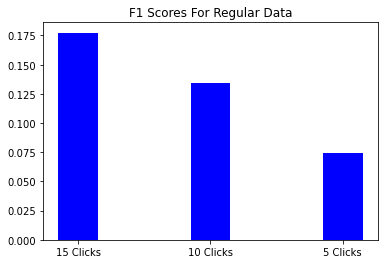

In [51]:
##Plot for not resampled data
import sklearn.metrics
f1_15 = metrics.f1_score(click15_nodown['True Labels'], click15_nodown['Predicted Labels'])
f1_10 = metrics.f1_score(click10_nodown['True Labels'], click10_nodown['Predicted Labels'])
f1_5 = metrics.f1_score(click5_nodown['True Labels'], click5_nodown['Predicted Labels'])
print('F1 scores: ', f1_15, f1_10, f1_5)
w = 0.3
clicks = ['15 Clicks', '10 Clicks', '5 Clicks']
f1s = [f1_15, f1_10, f1_5]
ax = plt.subplot()
ax.bar(clicks, f1s, width=w, color='b', align='center'), plt.title('F1 Scores For Regular Data')
plt.show()

F1 scores:  0.43613707165109034 0.4377880184331797 0.4297618344069499


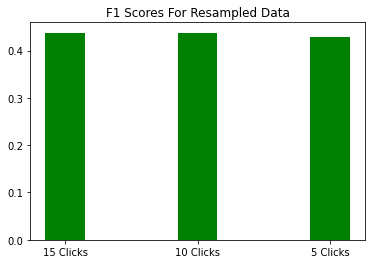

In [49]:
####Plot for Resampled Data
f1_15_2 = metrics.f1_score(click15_down['True Labels'], click15_down['Predicted Labels'])
f1_10_2 = metrics.f1_score(click10_down['True Labels'], click10_down['Predicted Labels'])
f1_5_2 = metrics.f1_score(clicks5_down['True Labels'], clicks5_down['Predicted Labels'])

print('F1 scores: ', f1_15_2, f1_10_2, f1_5_2)
w = 0.3
clicks = ['15 Clicks', '10 Clicks', '5 Clicks']
f1s_2 = [f1_15_2, f1_10_2, f1_5_2]
ax = plt.subplot()
ax.bar(clicks, f1s_2, width=w, color='g', align='center'), plt.title('F1 Scores For Resampled Data')
plt.show()

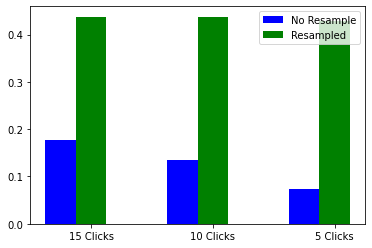

In [53]:
###Plot to compare resampled and regular data
x = np.arange(3)
fig = plt.figure()
ax = plt.subplot()
ax.bar(x, f1s, color = 'b', width = 0.25)
ax.bar(x + 0.25, f1s_2, color = 'g', width = 0.25, tick_label = ['15 Clicks', '10 Clicks', '5 Clicks'])
ax.legend(labels=['No Resample', 'Resampled'])

In [117]:
##########TRAIN MODEL##############


## ROUND 1
# param_grid = {
#     'max_depth': [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma': [0,0.25,1.0],
#     'reg_lambda': [0,1.0, 10.0],
#     'scale_pos_weight': [1,3,5]
# }

# RESULT of the first Round:
#        {'gamma': 0, 
#         'learning_rate': 0.05, 
#         'max_depth': 5, 
#         'reg_lambda': 10.0, 
#         'scale_pos_weight': 1}

## Round 2
param_grid = {
        'gamma': [0], 
        'learning_rate': [0.05], 
        'max_depth': [5, 6, 7],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [1]}

optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                                seed=123,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='f1',
    verbose = 0,
    n_jobs = 5,
    cv = 3
)

optimal_params.fit(X_train,
                   y_train,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(X_test, y_test)],
                  verbose=False)
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'reg_lambda': 10.0, 'scale_pos_weight': 1}


In [118]:
## Fit and Predict
preds = optimal_params.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.06909856190810243

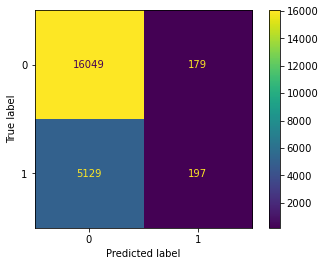

In [119]:
from sklearn.metrics import plot_confusion_matrix

plot_5_click_no_resample = plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d')

In [79]:
output_5_clicks = pd.DataFrame(data=preds, columns=['Predicted Labels'])
output_5_clicks['True Labels'] = y_test
output_5_clicks['Predicted == True'] = np.where(output_5_clicks["Predicted Labels"] == output_5_clicks['True Labels'], 1, 0)
output_5_clicks['Session Length'] = [len(x) for x in data['5_clicks']['X_test']]

output_5_clicks.head(10)

,Predicted Labels,True Labels,Predicted == True,Session Length
0,0,0,1,14
1,0,0,1,10
2,0,0,1,15
3,0,0,1,12
4,0,0,1,21
5,0,0,1,10
6,0,1,0,31
7,0,0,1,73
8,0,1,0,14
9,0,0,1,8


In [ ]:
f1_5_clicks

plt.bar()

In [80]:
#Save output as a csv
output_5_clicks.to_csv(r'C:\Users\Sam\OneDrive\Escritorio\Customer Data\5_clicks_no_downsample.csv')

In [98]:
############ 10 CLICKS####################

### Get the copy of the data
i = '10_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

### Downsampling the training data
### And keep the test data in shape
temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

class_0 = temp[temp.purchase == 0]
class_1 = temp[temp.purchase == 1]

class_0 = resample(class_0,
             replace=True,
             n_samples=len(class_1),
             random_state=123)


data_downsampled = pd.concat([class_0, class_1])

X_train = data_downsampled.session
y_train = data_downsampled.purchase

### Featurization
## Doing ngrams with n = 1 AND 2

one_gram, maping_1 = encode_sessions(X_train,n=1, mapping=None)
two_gram, maping_2 = encode_sessions(X_train,n=2, mapping=None)

maping_2 = {key: value + len(maping_1) for key,value in maping_2.items()}
maping = {**maping_1, **maping_2}
X_train = np.concatenate((one_gram, two_gram), axis=1)

# featurize X_test
X = np.zeros((len(X_test), len(maping)))
for i, session in enumerate(X_test):
    for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
        try:
            X[i, maping[ngram]] += 1
        except KeyError:
            pass
X_test = X

In [99]:
## Round 2
param_grid = {
        'gamma': [1], 
        'learning_rate': [0.1], 
        'max_depth': [4],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [3]}

optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                                seed=123,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='f1',
    verbose = 0,
    n_jobs = 5,
    cv = 3
)

optimal_params.fit(X_train,
                   y_train,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(X_test, y_test)],
                  verbose=False)
print(optimal_params.best_params_)

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 11.0, 'scale_pos_weight': 3}


In [100]:
## Fit and Predict
preds = optimal_params.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.41469675901165903

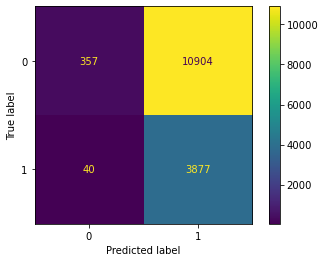

In [101]:
## Plot the confusion metrics
plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d')

In [102]:
output_10_clicks = pd.DataFrame(data=preds, columns=['Predicted Labels'])
output_10_clicks['True Labels'] = y_test
output_10_clicks['Predicted == True'] = np.where(output_10_clicks["Predicted Labels"] == output_10_clicks['True Labels'], 1, 0)
output_10_clicks['Session Length'] = [len(x) for x in data['10_clicks']['X_test']]

output_10_clicks.head(10)

,Predicted Labels,True Labels,Predicted == True,Session Length
0,1,0,0,17
1,1,0,0,17
2,1,1,1,18
3,1,0,0,18
4,1,0,0,26
5,1,0,0,24
6,1,0,0,16
7,1,0,0,21
8,1,0,0,33
9,1,1,1,16


In [103]:
output_10_clicks.to_csv(r'C:\Users\Sam\OneDrive\Escritorio\Customer Data\10_clicks_downsampled.csv')

In [110]:
################ 15 CLICKS ############################

### Get the copy of the data
i = '15_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

### Downsampling the training data
### And keep the test data in shape
temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

class_0 = temp[temp.purchase == 0]
class_1 = temp[temp.purchase == 1]

class_0 = resample(class_0,
             replace=True,
             n_samples=len(class_1),
             random_state=123)


data_downsampled = pd.concat([class_0, class_1])

X_train = data_downsampled.session
y_train = data_downsampled.purchase

### Featurization
## Doing ngrams with n = 1 AND 2

one_gram, maping_1 = encode_sessions(X_train,n=1, mapping=None)
two_gram, maping_2 = encode_sessions(X_train,n=2, mapping=None)

maping_2 = {key: value + len(maping_1) for key,value in maping_2.items()}
maping = {**maping_1, **maping_2}
X_train = np.concatenate((one_gram, two_gram), axis=1)

# featurize X_test
X = np.zeros((len(X_test), len(maping)))
for i, session in enumerate(X_test):
    for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
        try:
            X[i, maping[ngram]] += 1
        except KeyError:
            pass
X_test = X

In [111]:
optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                                seed=123,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='f1',
    verbose = 0,
    n_jobs = 5,
    cv = 3
)

optimal_params.fit(X_train,
                   y_train,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(X_test, y_test)],
                  verbose=False)
print(optimal_params.best_params_)

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 9.0, 'scale_pos_weight': 3}


In [112]:
## Fit and Predict
preds = optimal_params.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.4140975539151831

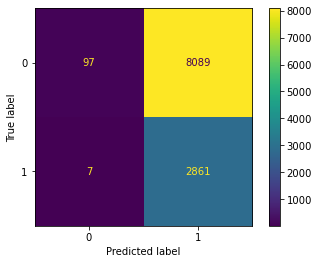

In [113]:
plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d')

In [114]:
output_15_clicks = pd.DataFrame(data=preds, columns=['Predicted Labels'])
output_15_clicks['True Labels'] = y_test
output_15_clicks['Predicted == True'] = np.where(output_15_clicks["Predicted Labels"] == output_15_clicks['True Labels'], 1, 0)
output_15_clicks['Session Length'] = [len(x) for x in data['15_clicks']['X_test']]

output_15_clicks.head(10)

,Predicted Labels,True Labels,Predicted == True,Session Length
0,1,0,0,18
1,1,0,0,24
2,1,0,0,24
3,1,1,1,40
4,1,0,0,85
5,1,0,0,43
6,1,1,1,18
7,1,1,1,29
8,1,0,0,20
9,1,0,0,22


In [115]:
output_15_clicks.to_csv(r'C:\Users\Sam\OneDrive\Escritorio\Customer Data\15_clicks_downsampled.csv')